In [12]:
from dataclasses import asdict

import math
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

from minitorch.module import Network, Linear
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid

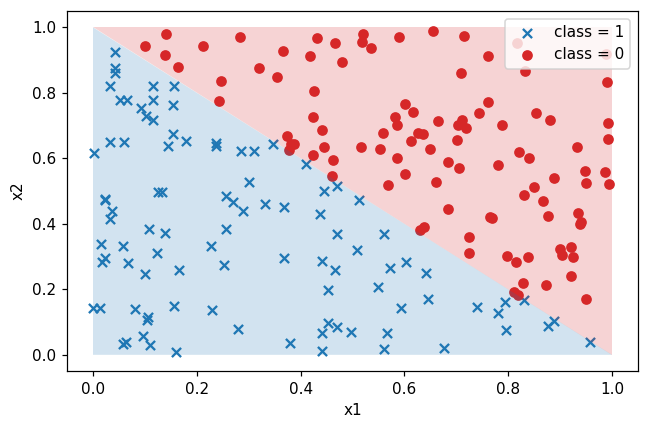

In [13]:
# Create a dataset
dataset_type = DatasetTypes.diagonal

datasets = Datasets.generate_datasets(n_samples=200)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue", label="class = 1")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red", label="class = 0")
ax.legend(loc=1)

bottom_left = Polygon([[0, 1], [1, 0], [0, 0]], color="tab:blue", alpha=0.2, lw=0.0)
top_right = Polygon([[0, 1], [1, 1], [1, 0]], color="tab:red", alpha=0.2, lw=0.0)
ax.add_patch(bottom_left)
ax.add_patch(top_right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

In [14]:
# Create a linear network
network = Network(input_dim=2, hidden_dim=5, output_dim=1)

In [15]:
# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.75)

In [16]:
# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [17]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X)
    
    # Apply nonlinearity 
    # y_hat = [[scalar.relu() for scalar in row] for row in y_hat]

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]

    # Compute a loss
    loss_per_epoch = 0
    for i in range(len(y_true)):
        loss_per_epoch += (y_hat[i][0].log() if y_true[i] == 1.0 else (- y_hat[i][0] + 1).log())
    loss_per_epoch = (- loss_per_epoch / len(y_true))
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

epoch 0: loss = 0.8368828349967786
epoch 10: loss = 0.692733416309597
epoch 20: loss = 0.6860226153099638
epoch 30: loss = 0.6790121453485507
epoch 40: loss = 0.6710029473888438
epoch 50: loss = 0.6613459668955237
epoch 60: loss = 0.6494480462112109
epoch 70: loss = 0.6348081897601308
epoch 80: loss = 0.6170580879908609
epoch 90: loss = 0.5960044355863091
epoch 100: loss = 0.5717019494785657
epoch 110: loss = 0.5445546235254335
epoch 120: loss = 0.5153616120024404
epoch 130: loss = 0.4852147203379027
epoch 140: loss = 0.45526492751399933
epoch 150: loss = 0.4264834590344293
epoch 160: loss = 0.3995298448496502
epoch 170: loss = 0.3747459741792573
epoch 180: loss = 0.3522263335353054
epoch 190: loss = 0.3319064740945673


In [18]:
y_hat = network.forward(X)
y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
y_hat_classes = [[1 if proba.data >= 0.5 else 0 for proba in row] for row in y_hat]
y_hat_classes = list(itertools.chain.from_iterable(y_hat_classes))

In [19]:
# Accuraccy
sum(
    [
        1 if y_hat_c == y_true_c 
        else 0 for (y_hat_c, y_true_c) in zip(y_hat_classes, y_true)
    ]
) / len(y_true)

0.945

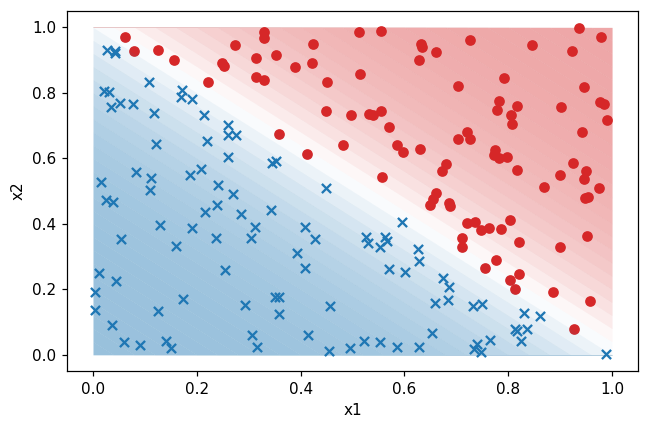

In [11]:
# Visualising predictions
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Visualise decision boundary

bias_positions = list(np.linspace(0, 2, 51))
x_range = list(np.linspace(0, 1, 51))

for bias_lower, bias_upper in zip(bias_positions, bias_positions[1:]):
    
    # Create corresponding x2 values for lower
    X_lower = [list((x1, bias_lower - x1)) for x1 in x_range]
    
    # Clamp values to between 0.0 and 1.0
    X_lower = [[x1, max(min(x2, 1.0), 0.0)] for (x1, x2) in X_lower]
    y_lower = network.forward(X_lower)
    y_mean_lower = sigmoid(sum(scalar[0].data for scalar in y_lower) / len(y_lower))

    # Create corresponding x2 values for upper
    X_upper = [list((x1, bias_upper - x1)) for x1 in x_range]
    
    # Clamp upper and lower bounds
    X_upper = [[x1, max(min(x2, 1.0), 0.0)] for (x1, x2) in X_upper]
    y_upper = network.forward(X_upper)
    y_mean_upper = sigmoid(sum(scalar[0].data for scalar in y_upper) / len(y_upper))

    # Plot and fill    
    ax.fill_between(
        x_range,
        [x2 for (_, x2) in X_lower],
        [x2 for (_, x2) in X_upper],
        alpha=(y_mean_lower - 0.5) if y_mean_lower >= 0.5 else (0.5 - y_mean_lower),
        color="tab:blue" if y_mean_lower >= 0.5 else "tab:red",
        lw=0.01
    )
    

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();